# **Project**. Planning with RRT


Nazerke Sandibay

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from matplotlib.pyplot import figure
import matplotlib.animation as animation
import time



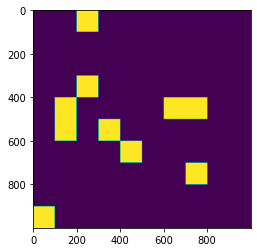

In [2]:
env_big = np.loadtxt('test_env.txt', dtype=int)
env=env_big
plt.imshow(env_big)

In [3]:
# def get_point(x):
#   zeros=np.argwhere(x == 0)
#   return list(random.choice(zeros))
# env=env_big
# start=get_point(env_big.T)
# goal=get_point(env_big.T)

# np.savetxt('start_env2.txt', start, fmt='%d')
# np.savetxt('goal_env2.txt', goal, fmt='%d')

In [4]:
start=np.loadtxt('start_env2.txt', dtype=int)
goal=np.loadtxt('goal_env2.txt', dtype=int)

In [5]:
start,goal

(array([100, 800]), array([800, 100]))

In [6]:
class Node():
  def __init__(self,parent=None,position=None,orientation=0):
    self.parent=parent
    self.position=position
    
  def __hash__(self):
    return hash(str(self.position))

  def __eq__(self, other):
    if not isinstance(other, type(self)): return NotImplemented
    return self.position == other.position

def get_nearest(nodes, rand_node):
    dist = [cost(a, rand_node) for a in nodes]
    min_node = dist.index(min(dist))
    return nodes[min_node]

def difference(node1,node2):
    delta= node2.position-node1.position 
    dist=math.sqrt(delta[0]**2+delta[1]**2)
    theta=math.atan2(delta[1],delta[0])
    return dist,theta

def cost(node1, node2):
    x=np.linalg.norm((node1.position-node2.position),2)
    return x

def termination(node1, node2):
    dif=node1.position-node2.position
    return math.sqrt(dif[0]**2+dif[1]**2)

def steer(openSet, nearest_node, rand_node, max_length):
    d, theta=difference(nearest_node, rand_node)
    if d>max_length:
        d=max_length
    x=int(nearest_node.position[0]+d*math.cos(theta))
    y=int(nearest_node.position[1]+d*math.sin(theta))
    new_node=Node(nearest_node,np.array(([x , y])))
    return new_node

def rrt(space, start, end, step, max_length=70,termination_value=30):
    
    start_node = Node(None, start)
    end_node = Node(None, end)
    openSet   = [start_node]
    i=0
    path=[]
    while i<step:     
        i=i+1
        pos=np.array(([random.randint(0, space.shape[0]) , random.randint(0, space.shape[1])]))
        node=Node(None, pos)
        nearest=get_nearest(openSet,node)
        new_node=steer(openSet, nearest, node, max_length)
        # print(new_node.position[0],new_node.position[1],space[new_node.position[0],new_node.position[1]])
        if new_node.position[0]>space.shape[0] or space[new_node.position[0],new_node.position[1]] or new_node.position[1]>space.shape[1]:
          continue
        # print(new_node.position[0],new_node.position[1],space[new_node.position[0],new_node.position[1]])

        openSet.append(new_node)

        if i%1000==0:
          print(i,termination(new_node,end_node))

        if termination(new_node,end_node)<termination_value:
#             print(new_node.position[::-1],end_node.position[::-1])
            end_node.parent=new_node
            openSet.append(end_node)
            current = end_node
            while current is not None:
                path.append((current.position[0],current.position[1]))
                current = current.parent
            print("Length of path: ", len(path))
            print("Iterations: ",i)
            return openSet,path[::-1]
    return openSet, path

def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,y1],[x2,y2],'r-')


def draw_nodes(openSet,space):
    plt.figure(figsize = (10,10))
    plt.title('All nodes', fontsize=20)
    for node in openSet:
        if not node.parent==None:
            connectpoints(node.position,node.parent.position,0,1)
        else:
            print(node.position)
    plt.imshow(space)

In [100]:
start_np,goal_np=np.array(start),np.array(goal)
openset,path=rrt(env.T,start_np,goal_np,10000,10)

1000 271.26555254952666
Length of path:  132
Iterations:  2336


In [101]:
def draw_path(path,space,start):
    plt.figure(figsize = (10,10))
    plt.title('Path', fontsize=20)
    start_p=start
    for node in path:
            connectpoints(start_p,node,0,1)
            start_p=node
    plt.imshow(space)


In [102]:
start,goal

(array([100, 800]), array([800, 100]))

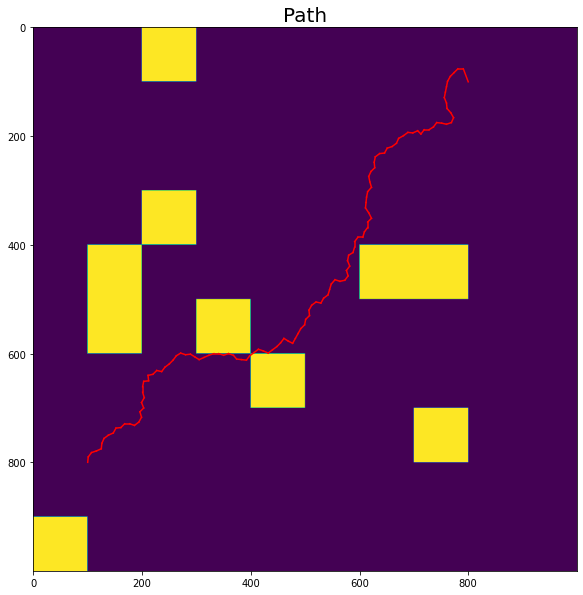

In [103]:
draw_path(path,env,start)

[100 800]


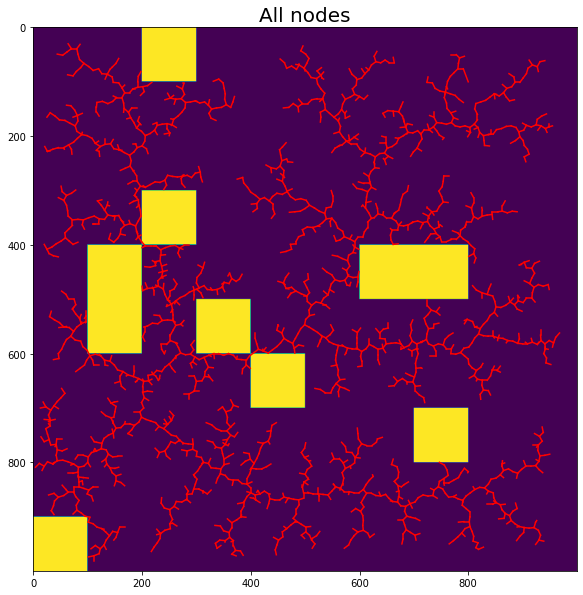

In [104]:
draw_nodes(openset,env)

# Parallel

In [105]:
from mpi4py import MPI

In [116]:
%%writefile rrt_parallel.py
import random
import math

import matplotlib.pyplot as plt
from mpi4py import MPI
import numpy as np

env = np.loadtxt('test_env.txt', dtype=int)
start=np.loadtxt('start_env2.txt', dtype=int)
goal=np.loadtxt('goal_env2.txt', dtype=int)

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

t1 = MPI.Wtime()
paths=[]

class Node():
  def __init__(self,parent=None,position=None,orientation=0):
    self.parent=parent
    self.position=position
    
  def __hash__(self):
    return hash(str(self.position))

  def __eq__(self, other):
    if not isinstance(other, type(self)): return NotImplemented
    return self.position == other.position

def get_nearest(nodes, rand_node):
    dist = [cost(a, rand_node) for a in nodes]
    min_node = dist.index(min(dist))
    return nodes[min_node]

def difference(node1,node2):
    delta= node2.position-node1.position 
    dist=math.sqrt(delta[0]**2+delta[1]**2)
    theta=math.atan2(delta[1],delta[0])
    return dist,theta

def cost(node1, node2):
    x=np.linalg.norm((node1.position-node2.position),2)
    return x

def termination(node1, node2):
    dif=node1.position-node2.position
    return math.sqrt(dif[0]**2+dif[1]**2)

def steer(openSet, nearest_node, rand_node, max_length):
    d, theta=difference(nearest_node, rand_node)
    if d>max_length:
        d=max_length
    x=int(nearest_node.position[0]+d*math.cos(theta))
    y=int(nearest_node.position[1]+d*math.sin(theta))
    new_node=Node(nearest_node,np.array(([x , y])))
    return new_node

def rrt(space, start, end, step, max_length=70,termination_value=30):
    
    start_node = Node(None, start)
    end_node = Node(None, end)
    openSet   = [start_node]
    i=0
    path=[]
    while i<step:     
        i=i+1
        pos=np.array(([random.randint(0, space.shape[0]) , random.randint(0, space.shape[1])]))
        node=Node(None, pos)
        nearest=get_nearest(openSet,node)
        new_node=steer(openSet, nearest, node, max_length)
        # print(new_node.position[0],new_node.position[1],space[new_node.position[0],new_node.position[1]])
        if new_node.position[0]>space.shape[0] or space[new_node.position[0],new_node.position[1]] or new_node.position[1]>space.shape[1]:
          continue
        # print(new_node.position[0],new_node.position[1],space[new_node.position[0],new_node.position[1]])

        openSet.append(new_node)

        if i%1000==0:
          print(i)

        if termination(new_node,end_node)<termination_value:
#             print(new_node.position[::-1],end_node.position[::-1])
            end_node.parent=new_node
            openSet.append(end_node)
            current = end_node
            while current is not None:
                path.append((current.position[0],current.position[1]))
                current = current.parent
            print("Length of path: ", len(path))
            print("Iterations: ",i)
            return openSet,path[::-1]
    return openSet, path

def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,y1],[x2,y2],'r-')
    
def draw_path(path,space,start):
    plt.figure(figsize = (10,10))
    plt.title('Path', fontsize=20)
    start_p=start
    for node in path:
            connectpoints(start_p,node,0,1)
            start_p=node
    plt.imshow(space)
    plt.savefig(f'path_short{len(path)}.png')
    
print(rank)
print(start,goal,rank)
openset,path=rrt(env.T,start,goal,2000,10)
t2 = MPI.Wtime()  


m=len(path) 
if m==0:
    m=env.shape[0]**2

sendbuf = np.array([m], dtype='float64')    
recvbuf = None

if rank==0:
     recvbuf = np.zeros(1, dtype='float64')
     
print()    
comm.Reduce(sendbuf, recvbuf, op = MPI.MIN, root = 0)
ans = comm.gather([path,m], root=0)
if rank==0:
     print("Minimum length ", recvbuf)
     paths.append(ans)
     ans=sorted(paths[0], key=lambda element : element[1])[0]
     
     if ans[1] < env.shape[0]**2:
        draw_path(ans[0],env,start)





Overwriting rrt_parallel.py


In [117]:
%time !python3 rrt_parallel.py

0
[100 800] [800 100] 0
1000
2000

Minimum length  [1000000.]
CPU times: user 97.2 ms, sys: 14.7 ms, total: 112 ms
Wall time: 8.88 s


In [118]:
%time !mpirun -n 4 python rrt_parallel.py

3
[100 800] [800 100] 3
Length of path:  121
Iterations:  691

1
[100 800] [800 100] 1
Length of path:  126
Iterations:  737

2
[100 800] [800 100] 2
1000
2000

0
[100 800] [800 100] 0
1000
2000

Minimum length  [121.]
CPU times: user 99.5 ms, sys: 26.2 ms, total: 126 ms
Wall time: 10.2 s
